Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor
import lightgbm as lgb
import numpy as np
import catboost as cb

In [2]:
cars = pd.read_csv('/datasets/autos.csv')
cars.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
cars['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Как мы видим, в целом ряде столбцов есть пропуски, а в годах выпуска машин - неадекватные значения.

In [5]:
# оставим только реальные года выпуска машин
cars = cars.drop(cars[cars['RegistrationYear'] < 1910].index)
cars = cars.drop(cars[cars['RegistrationYear'] > 2019].index)

# объединим месяц и год выпуска в одby столбец 
cars['RegistrationMonth'] = cars['RegistrationMonth'].replace(0, 6) # заменим месяц 0 на среднее значение (июнь)
cars['RegistrationDate'] = pd.to_datetime(dict(year=cars['RegistrationYear'], month=cars['RegistrationMonth'], day=1))
cars = cars.drop(['RegistrationYear', 'RegistrationMonth'], axis=1)

# заполним пропуски
cars['VehicleType'] = cars['VehicleType'].fillna('other')
cars['Model'] = cars['Model'].fillna('etc')
cars['Gearbox'] = cars['Gearbox'].fillna('unknown')
cars['FuelType'] = cars['FuelType'].fillna('unknown')
cars['NotRepaired'] = cars['NotRepaired'].fillna('unknown')

# переведем данные в корректный формат
cars['DateCrawled'] = pd.to_datetime(cars['DateCrawled'])
cars['DateCreated'] = pd.to_datetime(cars['DateCreated'])
cars['LastSeen'] = pd.to_datetime(cars['LastSeen'])
cars['DateCrawled'] = pd.to_numeric(cars['DateCrawled'])
cars['DateCreated'] = pd.to_numeric(cars['DateCreated'])
cars['LastSeen'] = pd.to_numeric(cars['LastSeen'])
cars['RegistrationDate'] = pd.to_numeric(cars['RegistrationDate'])

cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 15 columns):
DateCrawled         354198 non-null int64
Price               354198 non-null int64
VehicleType         354198 non-null object
Gearbox             354198 non-null object
Power               354198 non-null int64
Model               354198 non-null object
Kilometer           354198 non-null int64
FuelType            354198 non-null object
Brand               354198 non-null object
NotRepaired         354198 non-null object
DateCreated         354198 non-null int64
NumberOfPictures    354198 non-null int64
PostalCode          354198 non-null int64
LastSeen            354198 non-null int64
RegistrationDate    354198 non-null int64
dtypes: int64(9), object(6)
memory usage: 43.2+ MB


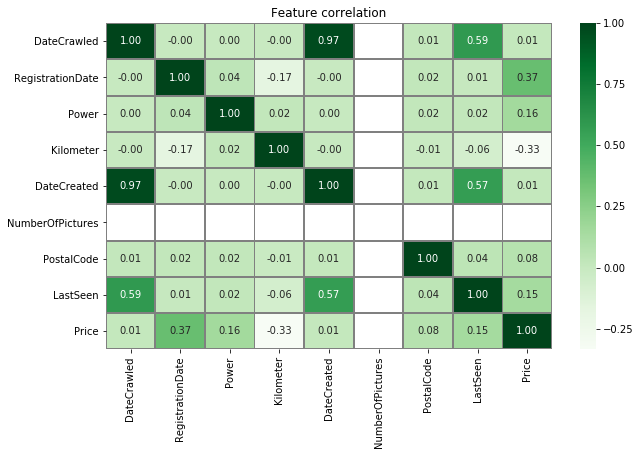

In [6]:
numeric = ['DateCrawled', 'RegistrationDate', 'Power', 'Kilometer', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',  'Price']
cm = cars[numeric].corr()
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cm, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="Greens")
ax.set_title('Feature correlation')
plt.show()

Видим, что даты создания и выгрузки объявлений сильно коррелируют, поэтому избавимся от даты выгрузки. Уберем также количество фотографий, ведь там все значения равны 0.

Для работы с моделями RandomForest и LinearRegression уберем также категориальные признаки со слишком большим набором значений (модель и индекс продавца).

In [7]:
cars2 = cars.drop(['NumberOfPictures', 'DateCrawled', 'Model', 'PostalCode'], axis=1)

In [8]:
cars2 = pd.get_dummies(cars2)
cars2.head()

,Price,Power,Kilometer,DateCreated,LastSeen,RegistrationDate,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes
0,480,0,150000,1458777600000000000,1459999017000000000,738892800000000000,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,18300,190,125000,1458777600000000000,1459993610000000000,1304208000000000000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,163,125000,1457913600000000000,1459860466000000000,1091318400000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,75,150000,1458172800000000000,1458236417000000000,991353600000000000,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,3600,69,90000,1459382400000000000,1459937841000000000,1214870400000000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# 2. Обучение моделей

#### 2.1 Линейная регрессия

In [9]:
X = cars2.drop('Price', axis=1)
y = cars2['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
%%time
model = LinearRegression()
model.fit(X_train, y_train)

CPU times: user 3.86 s, sys: 850 ms, total: 4.72 s
Wall time: 4.72 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
%%time
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions)**(1/2)
rmse

CPU times: user 16.7 ms, sys: 20.7 ms, total: 37.4 ms
Wall time: 9.88 ms


3064.3485452041614

#### 2.2 Случайный лес

In [12]:
%%time
model2 = RandomForestRegressor(random_state=1, min_samples_split=5, min_samples_leaf=3, max_depth=20)
model2.fit(X_train, y_train)

CPU times: user 28.1 s, sys: 0 ns, total: 28.1 s
Wall time: 28.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [13]:
%%time
predictions2 = model2.predict(X_test)
rmse2 = mean_squared_error(y_test, predictions2)**(1/2)
rmse2

CPU times: user 331 ms, sys: 0 ns, total: 331 ms
Wall time: 337 ms


1824.9222822519203

#### 2.3 CatBoost

Для работы с моделями CatBoost и LightGBM вернем в данные индекс и модель машины.

In [14]:
cars3 = cars.drop(['NumberOfPictures', 'DateCrawled'], axis=1)
cars3.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,RegistrationDate
0,480,other,manual,0,golf,150000,petrol,volkswagen,unknown,1458777600000000000,70435,1459999017000000000,738892800000000000
1,18300,coupe,manual,190,etc,125000,gasoline,audi,yes,1458777600000000000,66954,1459993610000000000,1304208000000000000
2,9800,suv,auto,163,grand,125000,gasoline,jeep,unknown,1457913600000000000,90480,1459860466000000000,1091318400000000000
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,1458172800000000000,91074,1458236417000000000,991353600000000000
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,1459382400000000000,60437,1459937841000000000,1214870400000000000


In [15]:
X = cars3.drop('Price', axis=1)
y = cars3['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

numeric = ['Power', 'Kilometer', 'DateCreated', 'LastSeen', 'RegistrationDate']

scaler2 = StandardScaler()
scaler2.fit(X_train[numeric])

X_train[numeric] = scaler2.transform(X_train[numeric])
X_test[numeric] = scaler2.transform(X_test[numeric])

In [16]:
# %%time
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# train_pool = cb.Pool(X_train, label=y_train, cat_features=cat_features)
# model31 = CatBoostRegressor(cat_features=cat_features, iterations=50)
# randomized_search_result = model31.randomized_search(grid, X=train_pool,
#                                                    plot=True, n_iter=5)
# randomized_search_result

In [17]:
%%time
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']
model3 = CatBoostRegressor(iterations=150, verbose=50, learning_rate=0.1, random_state=1, depth=10, l2_leaf_reg=3) 
model3.fit(X_train, y_train, cat_features=cat_features) 

0:	learn: 4188.5702179	total: 892ms	remaining: 2m 12s
50:	learn: 1842.9778338	total: 34.6s	remaining: 1m 7s
100:	learn: 1740.1533825	total: 1m 8s	remaining: 33.2s
149:	learn: 1682.2635186	total: 1m 41s	remaining: 0us
CPU times: user 1min 36s, sys: 7.33 s, total: 1min 43s
Wall time: 1min 44s


In [18]:
%%time
predictions3 = model3.predict(X_test)
rmse3 = mean_squared_error(y_test, predictions3)**(1/2)
rmse3

CPU times: user 405 ms, sys: 30 ms, total: 435 ms
Wall time: 430 ms


1742.0083322283351

#### 2.4 LightGBM

In [19]:
for col in cat_features:
    X_train[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [20]:
%%time
gbm = lgb.LGBMRegressor(
                        learning_rate=0.05,
                        n_estimators=150, random_state=1, max_depth=10, num_leaves=50
)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        early_stopping_rounds=5, verbose=50)

Training until validation scores don't improve for 5 rounds
[50]	valid_0's rmse: 1913.24	valid_0's l2: 3.66047e+06
[100]	valid_0's rmse: 1766.06	valid_0's l2: 3.11898e+06
[150]	valid_0's rmse: 1735.92	valid_0's l2: 3.01341e+06
Did not meet early stopping. Best iteration is:
[150]	valid_0's rmse: 1735.92	valid_0's l2: 3.01341e+06
CPU times: user 42.6 s, sys: 100 ms, total: 42.7 s
Wall time: 43.2 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=50, objective=None,
              random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
%%time
predictions4 = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
rmse4 = mean_squared_error(y_test, predictions4)**(1/2)
rmse4

CPU times: user 3.22 s, sys: 7.87 ms, total: 3.22 s
Wall time: 3.29 s


1735.9181875057232

#### 2.5 Константная модель

In [22]:
rmse5 = mean_squared_error(y_test, np.full(len(y_test), y_train.median()))**(1/2)
rmse5

4861.611851180789

# 3. Анализ моделей

- `Линейная регрессия`: RMSE - 3064, время обучения - 5 с, время предсказания - < 1 с
- `Случайный лес`: RMSE - 1825, время обучения - 26 с, время предсказания - <  1 с
- `CatBoost`: RMSE - 1742, время обучения - 106 с, время предсказания - < 1 с
- `LightGBM`: RMSE - 1735, время обучения - 43 с, время предсказания - 3 с
- `Константная модель`: RMSE - 4861

Как мы видим, все наши модели работают неплохо по сравнению с константной моделью.

Оптимальное сочетание точности и времени работы показала модель LightGBM, поэтому стоит выбрать победителем именно её.